# Creating Graph Database of Lawmakers, Committees, and Bills

In this Project, Joy and Sonya:
* working with a ProPublica API
* create nodes for Senators and active Senate Bills
* create edges for "sponsorship" -- a senator sponsors a bill

The goal:
* explore centrality measures

## Import Needed Packages

In [1]:
import requests
import json
import networkx as net
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Create Function to Run API

In [3]:
def propublica(url):
    r = requests.get(url, headers={'X-API-Key': '###REDACTED###'})  
    data = json.loads(r.text)
    return (data)

## Get List of Senators via API

In [4]:
senators = propublica("https://api.propublica.org/congress/v1/115/senate/members.json")['results'][0]['members']
df_senators = pd.DataFrame(senators)
df_senators

,api_uri,contact_form,crp_id,cspan_id,date_of_birth,dw_nominate,facebook_account,fax,first_name,google_entity_id,...,seniority,state,state_rank,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
0,https://api.propublica.org/congress/v1/members...,http://www.alexander.senate.gov/public/index.c...,N00009888,5,1940-07-03,0.323,senatorlamaralexander,202-228-3398,Lamar,/m/01rbs3,...,15,TN,senior,0,203,SenAlexander,https://www.alexander.senate.gov/public/,98.47,15691,lamaralexander
1,https://api.propublica.org/congress/v1/members...,https://www.blunt.senate.gov/public/index.cfm/...,N00005195,45465,1950-01-10,0.431,SenatorBlunt,202-224-8149,Roy,/m/034fn4,...,7,MO,junior,0,203,RoyBlunt,https://www.blunt.senate.gov/public/,99.01,418,SenatorBlunt
2,https://api.propublica.org/congress/v1/members...,http://www.brown.senate.gov/contact/,N00003535,5051,1952-11-09,-0.440,None,202-228-6321,Sherrod,/m/034s80,...,11,OH,senior,1,203,SenSherrodBrown,https://www.brown.senate.gov/,95.07,27018,SherrodBrownOhio
3,https://api.propublica.org/congress/v1/members...,https://www.burr.senate.gov/contact/email,N00002221,31054,1955-11-30,0.454,SenatorRichardBurr,202-228-2981,Richard,/m/03g_s9,...,13,NC,senior,0,203,SenatorBurr,https://www.burr.senate.gov/,99.48,21787,SenatorRichardBurr
4,https://api.propublica.org/congress/v1/members...,https://www.baldwin.senate.gov/feedback,N00004367,57884,1962-02-11,-0.546,TammyBaldwin,202-225-6942,Tammy,/m/024v02,...,5,WI,junior,1,203,SenatorBaldwin,https://www.baldwin.senate.gov/,95.57,3470,witammybaldwin
5,https://api.propublica.org/congress/v1/members...,https://www.boozman.senate.gov/public/index.cf...,N00013873,92069,1950-12-10,0.402,JohnBoozman,202-228-1371,John,/m/024s3v,...,7,AR,senior,0,203,JohnBoozman,https://www.boozman.senate.gov/public/,98.52,27958,BoozmanPressOffice
6,https://api.propublica.org/congress/v1/members...,https://www.barrasso.senate.gov/public/index.c...,N00006236,1024777,1952-07-21,0.528,johnbarrasso,202-224-1724,John,/m/02rsm32,...,11,WY,junior,0,203,SenJohnBarrasso,https://www.barrasso.senate.gov/,99.01,52662,barrassowyo
7,https://api.propublica.org/congress/v1/members...,https://www.bennet.senate.gov/?p=contact,N00030608,1031622,1964-11-28,-0.208,senbennetco,202-228-5097,Michael,/m/05b60qf,...,9,CO,senior,1,203,SenBennetCo,https://www.bennet.senate.gov/,91.58,110942,SenatorBennet
8,https://api.propublica.org/congress/v1/members...,https://www.blumenthal.senate.gov/contact/,N00031685,21799,1946-02-13,-0.418,SenBlumenthal,202-224-9673,Richard,/m/03tg8m,...,7,CT,senior,1,203,SenBlumenthal,https://www.blumenthal.senate.gov/,90.59,1568,SenatorBlumenthal
9,https://api.propublica.org/congress/v1/members...,https://www.booker.senate.gov/?p=contact,N00035267,84679,1969-04-27,-0.588,None,202-224-8378,Cory,/m/06p430,...,5,NJ,junior,1,203,CoryBooker,https://www.booker.senate.gov/,83.66,76151,SenCoryBooker


### Show the Column Names

In [5]:
df_senators.columns

Index([u'api_uri', u'contact_form', u'crp_id', u'cspan_id', u'date_of_birth',
       u'dw_nominate', u'facebook_account', u'fax', u'first_name',
       u'google_entity_id', u'govtrack_id', u'icpsr_id', u'id', u'ideal_point',
       u'in_office', u'last_name', u'leadership_role', u'lis_id',
       u'middle_name', u'missed_votes', u'missed_votes_pct', u'next_election',
       u'ocd_id', u'office', u'party', u'phone', u'rss_url', u'senate_class',
       u'seniority', u'state', u'state_rank', u'total_present', u'total_votes',
       u'twitter_account', u'url', u'votes_with_party_pct', u'votesmart_id',
       u'youtube_account'],
      dtype='object')

### Show IDs of Senators

In [6]:
df_senators['id'].head()

0    A000360
1    B000575
2    B000944
3    B001135
4    B001230
Name: id, dtype: object

## Get Recent Active Bills

The API will only send 20 at a go, so we have to paginate!

In [7]:
url = "https://api.propublica.org/congress/v1/115/senate/bills/active.json?offset="
offset = 0
apiResults = propublica(url + str(offset))
activeBills = apiResults['results'][0]['bills']
while True:
    offset = offset + 20
    apiResults = propublica(url + str(offset))
    moreBills = apiResults['results'][0]['bills']
    if len(moreBills) == 0:
        break
    activeBills += moreBills
    time.sleep(.25)  # Be friendly and don't overwhelm the server with a bunch of fast queries

In [8]:
len(activeBills)

365

In [9]:
pd.DataFrame(activeBills).columns

Index([u'active', u'bill_id', u'bill_slug', u'bill_type', u'bill_uri',
       u'committee_codes', u'committees', u'congressdotgov_url', u'cosponsors',
       u'enacted', u'govtrack_url', u'gpo_pdf_uri', u'house_passage',
       u'introduced_date', u'latest_major_action', u'latest_major_action_date',
       u'number', u'primary_subject', u'senate_passage', u'short_title',
       u'sponsor_id', u'sponsor_name', u'sponsor_party', u'sponsor_state',
       u'sponsor_title', u'sponsor_uri', u'subcommittee_codes', u'summary',
       u'summary_short', u'title', u'vetoed'],
      dtype='object')

In [10]:
pd.DataFrame(activeBills).head()

,active,bill_id,bill_slug,bill_type,bill_uri,committee_codes,committees,congressdotgov_url,cosponsors,enacted,...,sponsor_name,sponsor_party,sponsor_state,sponsor_title,sponsor_uri,subcommittee_codes,summary,summary_short,title,vetoed
0,True,s1866-115,s1866,s,https://api.propublica.org/congress/v1/115/bil...,[],,https://www.congress.gov/bill/115th-congress/s...,0,None,...,Lamar Alexander,R,TN,Sen.,https://api.propublica.org/congress/v1/members...,[],,,"Hurricanes Harvey, Irma, and Maria Education R...",None
1,True,s1519-115,s1519,s,https://api.propublica.org/congress/v1/115/bil...,[SSAS],Senate Armed Services Committee,https://www.congress.gov/bill/115th-congress/s...,0,None,...,John McCain,R,AZ,Sen.,https://api.propublica.org/congress/v1/members...,[],National Defense Authorization Act for Fiscal ...,National Defense Authorization Act for Fiscal ...,National Defense Authorization Act for Fiscal ...,None
2,True,s1057-115,s1057,s,https://api.propublica.org/congress/v1/115/bil...,[SSCM],"Senate Commerce, Science, and Transportation C...",https://www.congress.gov/bill/115th-congress/s...,7,None,...,Bill Nelson,D,FL,Sen.,https://api.propublica.org/congress/v1/members...,[],,,Harmful Algal Bloom and Hypoxia Research and C...,None
3,True,s1028-115,s1028,s,https://api.propublica.org/congress/v1/115/bil...,"[SPAG, SSHR]",Senate Aging Committee,https://www.congress.gov/bill/115th-congress/s...,14,None,...,Susan Collins,R,ME,Sen.,https://api.propublica.org/congress/v1/members...,[],(This measure has not been amended since it wa...,(This measure has not been amended since it wa...,RAISE Family Caregivers Act,None
4,True,s870-115,s870,s,https://api.propublica.org/congress/v1/115/bil...,[SSFI],Senate Finance Committee,https://www.congress.gov/bill/115th-congress/s...,21,None,...,Orrin G. Hatch,R,UT,Sen.,https://api.propublica.org/congress/v1/members...,[],Creating High-Quality Results and Outcomes Nec...,Creating High-Quality Results and Outcomes Nec...,Creating High-Quality Results and Outcomes Nec...,None


## Create a Graph Using NetworkX

In [130]:
simplifiedSenators = [dict.fromkeys(["id", "first_name", "middle_name", "last_name", "party", "seniority", "party_rank"])]
simplifiedBills = [dict.fromkeys(['bill_id','sponsor_id','primary_subject','sponsor_party'])]

In [131]:
for senator in senators:
    simplifiedSenator = {key: senator[key] for key in senator if key in \
                      ['id','first_name','middle_name','last_name','party','seniority','state_rank']}
    simplifiedSenators.append(simplifiedSenator)

Let's take a look at the simplified senators:

In [132]:
pd.DataFrame(simplifiedSenators).head()

,first_name,id,last_name,middle_name,party,party_rank,seniority,state_rank
0,None,None,None,None,None,NaN,None,NaN
1,Lamar,A000360,Alexander,None,R,NaN,15,senior
2,Roy,B000575,Blunt,None,R,NaN,7,junior
3,Sherrod,B000944,Brown,None,D,NaN,11,senior
4,Richard,B001135,Burr,M.,R,NaN,13,senior


That "None" row is going to cause a problem!  I'll remove it.

In [133]:
simplifiedSenators.pop(0)
pd.DataFrame(simplifiedSenators).head()

,first_name,id,last_name,middle_name,party,seniority,state_rank
0,Lamar,A000360,Alexander,None,R,15,senior
1,Roy,B000575,Blunt,None,R,7,junior
2,Sherrod,B000944,Brown,None,D,11,senior
3,Richard,B001135,Burr,M.,R,13,senior
4,Tammy,B001230,Baldwin,None,D,5,junior


In [134]:
for activeBill in activeBills:
    simplifiedBill = {key: activeBill[key] for key in activeBill if key in \
                      ['bill_id','sponsor_id','primary_subject','sponsor_party']}
    simplifiedBills.append(simplifiedBill)

Let's take a look at the simplified bills:

In [135]:
pd.DataFrame(simplifiedBills).head()

,bill_id,primary_subject,sponsor_id,sponsor_party
0,None,None,None,None
1,s1866-115,Education,A000360,R
2,s1519-115,Armed Forces and National Security,M000303,R
3,s1057-115,Environmental Protection,N000032,D
4,s1028-115,Families,C001035,R


That "None" row is going to cause a problem!  I'll remove it.

In [136]:
simplifiedBills.pop(0)
pd.DataFrame(simplifiedBills).head()

,bill_id,primary_subject,sponsor_id,sponsor_party
0,s1866-115,Education,A000360,R
1,s1519-115,Armed Forces and National Security,M000303,R
2,s1057-115,Environmental Protection,N000032,D
3,s1028-115,Families,C001035,R
4,s870-115,Health,H000338,R


In [137]:
g = net.Graph()
for senator in simplifiedSenators:
    if (senator['id'] != None):
        g.add_node(senator['id'], attr_dict=senator)

In [138]:
for bill in simplifiedBills:
    g.add_node(bill['bill_id'], attr_dict=bill)
    if (bill['sponsor_id']!=None and bill['bill_id']!=None):
        g.add_edge(bill['sponsor_id'],bill['bill_id'])

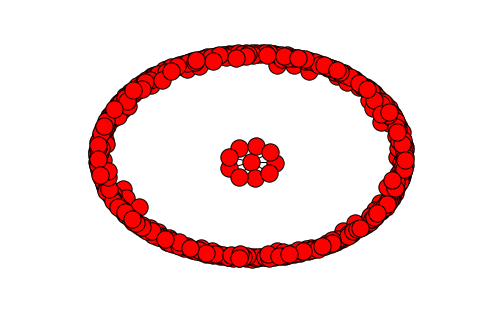

In [139]:
net.draw(g)

## Check Graph

In [140]:
g.nodes()

[u'L000174',
 u'sres3-115',
 u'sres98-115',
 u's1359-115',
 u'sres89-115',
 u'sres112-115',
 u'sres1-115',
 u'sres258-115',
 u'sres151-115',
 u'sconres23-115',
 u'sres111-115',
 u's317-115',
 u'sres57-115',
 u'W000437',
 u'D000622',
 u'sres193-115',
 u'sres113-115',
 u's199-115',
 u's363-115',
 u's81-115',
 u's55-115',
 u'sres4-115',
 u'sres173-115',
 u'I000055',
 u'S000148',
 u'sres231-115',
 u's860-115',
 u'sres69-115',
 u's916-115',
 u'sres203-115',
 u'sres171-115',
 u's513-115',
 u's385-115',
 u'B001277',
 u's1182-115',
 u's705-115',
 u'sres130-115',
 u's722-115',
 u'sres238-115',
 u'sres152-115',
 u's484-115',
 u'C001070',
 u'C001071',
 u'C001075',
 u's343-115',
 u's1757-115',
 u'S001194',
 u's61-115',
 u'sres118-115',
 u's167-115',
 u'sres257-115',
 u'sres131-115',
 u's488-115',
 u'sres153-115',
 u's987-115',
 u'H001075',
 u's518-115',
 u's63-115',
 u's110-115',
 u'sres68-115',
 u's867-115',
 u's168-115',
 u'sjres36-115',
 u's1057-115',
 u'sres86-115',
 u'B001288',
 u'P000595',
 

In [141]:
g.edges()

[(u'sres3-115', u'M000355'),
 (u'sres98-115', u'T000464'),
 (u's1359-115', u'B001261'),
 (u'sres89-115', u'E000285'),
 (u'sres112-115', u'B001135'),
 (u'sres1-115', u'M000355'),
 (u'sres258-115', u'C000141'),
 (u'sres151-115', u'B000575'),
 (u'sconres23-115', u'H001042'),
 (u'sres111-115', u'S001198'),
 (u's317-115', u'L000575'),
 (u'sres57-115', u'M000355'),
 (u'W000437', u's129-115'),
 (u'W000437', u'sres149-115'),
 (u'W000437', u'sres166-115'),
 (u'W000437', u'sres214-115'),
 (u'W000437', u's168-115'),
 (u'W000437', u's1052-115'),
 (u'W000437', u's518-115'),
 (u'D000622', u's496-115'),
 (u'D000622', u'sres187-115'),
 (u'sres193-115', u'K000384'),
 (u'sres113-115', u'M001111'),
 (u's199-115', u'B001261'),
 (u's363-115', u'K000367'),
 (u's81-115', u'K000367'),
 (u's55-115', u'G000555'),
 (u'sres4-115', u'M000355'),
 (u'sres173-115', u'G000386'),
 (u'I000055', u'sres140-115'),
 (u'I000055', u's1024-115'),
 (u'I000055', u'sres43-115'),
 (u'I000055', u's1598-115'),
 (u'S000148', u'sres8-

## Check for Isolates

All bills have a senator who sponsor them, but it's possible we have senators who haven't sponsored anything.  Is that the case?

In [142]:
net.isolates(g)

[u'L000174',
 u'S000033',
 u'K000393',
 u'S000770',
 u'D000563',
 u'T000476',
 u'C001113',
 u'L000577',
 u'C001095',
 u'S001202',
 u'V000128',
 u'S001141',
 u'H001076',
 u'S001197']

In [143]:
net.get_node_attributes(g,'party')

{u'A000360': u'R',
 u'B000575': u'R',
 u'B000944': u'D',
 u'B001135': u'R',
 u'B001230': u'D',
 u'B001236': u'R',
 u'B001261': u'R',
 u'B001267': u'D',
 u'B001277': u'D',
 u'B001288': u'D',
 u'C000127': u'D',
 u'C000141': u'D',
 u'C000174': u'D',
 u'C000567': u'R',
 u'C000880': u'R',
 u'C001035': u'R',
 u'C001047': u'R',
 u'C001056': u'R',
 u'C001070': u'D',
 u'C001071': u'R',
 u'C001075': u'R',
 u'C001088': u'D',
 u'C001095': u'R',
 u'C001098': u'R',
 u'C001113': u'D',
 u'D000563': u'D',
 u'D000607': u'D',
 u'D000618': u'R',
 u'D000622': u'D',
 u'E000285': u'R',
 u'E000295': u'R',
 u'F000062': u'D',
 u'F000444': u'R',
 u'F000457': u'D',
 u'F000463': u'R',
 u'G000359': u'R',
 u'G000386': u'R',
 u'G000555': u'D',
 u'G000562': u'R',
 u'H000338': u'R',
 u'H001041': u'R',
 u'H001042': u'D',
 u'H001046': u'D',
 u'H001061': u'R',
 u'H001069': u'D',
 u'H001075': u'D',
 u'H001076': u'D',
 u'I000024': u'R',
 u'I000055': u'R',
 u'J000293': u'R',
 u'K000367': u'D',
 u'K000383': u'I',
 u'K000384':

In [144]:
net.degree(g)

{u'A000360': 6,
 u'B000575': 5,
 u'B000944': 2,
 u'B001135': 8,
 u'B001230': 1,
 u'B001236': 5,
 u'B001261': 6,
 u'B001267': 1,
 u'B001277': 1,
 u'B001288': 2,
 u'C000127': 5,
 u'C000141': 10,
 u'C000174': 3,
 u'C000567': 1,
 u'C000880': 1,
 u'C001035': 6,
 u'C001047': 2,
 u'C001056': 9,
 u'C001070': 6,
 u'C001071': 7,
 u'C001075': 2,
 u'C001088': 5,
 u'C001095': 0,
 u'C001098': 2,
 u'C001113': 0,
 u'D000563': 0,
 u'D000607': 4,
 u'D000618': 7,
 u'D000622': 2,
 u'E000285': 3,
 u'E000295': 1,
 u'F000062': 6,
 u'F000444': 5,
 u'F000457': 1,
 u'F000463': 6,
 u'G000359': 3,
 u'G000386': 11,
 u'G000555': 3,
 u'G000562': 7,
 u'H000338': 6,
 u'H001041': 4,
 u'H001042': 5,
 u'H001046': 2,
 u'H001061': 2,
 u'H001069': 5,
 u'H001075': 2,
 u'H001076': 0,
 u'I000024': 2,
 u'I000055': 4,
 u'J000293': 6,
 u'K000367': 9,
 u'K000383': 2,
 u'K000384': 8,
 u'K000393': 0,
 u'L000174': 0,
 u'L000575': 4,
 u'L000577': 0,
 u'M000133': 1,
 u'M000303': 4,
 u'M000355': 16,
 u'M000639': 6,
 u'M000934': 8,
 u'M0

In [145]:
g.size()

364

In [146]:
net.number_of_nodes(g)

465

In [147]:
g.number_of_edges()

364

In [152]:
dg = net.degree_centrality(g)

In [149]:
dg_sorted = sorted(dg.iteritems(),key=lambda(k,v):(-v,k))
dg_sorted

[(u'M000355', 0.034482758620689655),
 (u'M001153', 0.028017241379310345),
 (u'G000386', 0.023706896551724137),
 (u'C000141', 0.021551724137931036),
 (u'C001056', 0.01939655172413793),
 (u'K000367', 0.01939655172413793),
 (u'B001135', 0.017241379310344827),
 (u'K000384', 0.017241379310344827),
 (u'M000934', 0.017241379310344827),
 (u'C001071', 0.015086206896551723),
 (u'D000618', 0.015086206896551723),
 (u'G000562', 0.015086206896551723),
 (u'R000595', 0.015086206896551723),
 (u'W000437', 0.015086206896551723),
 (u'W000779', 0.015086206896551723),
 (u'A000360', 0.01293103448275862),
 (u'B001261', 0.01293103448275862),
 (u'C001035', 0.01293103448275862),
 (u'C001070', 0.01293103448275862),
 (u'F000062', 0.01293103448275862),
 (u'F000463', 0.01293103448275862),
 (u'H000338', 0.01293103448275862),
 (u'J000293', 0.01293103448275862),
 (u'M000639', 0.01293103448275862),
 (u'P000449', 0.01293103448275862),
 (u'S001198', 0.01293103448275862),
 (u'B000575', 0.010775862068965518),
 (u'B001236', 

In [151]:
eg = net.eigenvector_centrality(g)
eg_sorted = sorted(eg.iteritems(),key=lambda(k,v):(-v,k))
eg_sorted

NetworkXError: eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))